## Import Library

In [1]:
# Standard library 
import os
import io
import time
import copy

# Data handling & visualization 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights

# Metrics & evaluation 
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Utilities 
from tqdm import tqdm
from ipywidgets import FileUpload
from IPython.display import display

## Training Configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 5
batch_size = 24
num_epochs = 10
num_workers = 2
learning_rate = 1e-4

## Data Augmentation + Preprocessing

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## Dataset Preparation

In [4]:
# Path to your dataset (local machine)
data_dir = r"C:\Users\ChrisBear\Python 3 General Notebook\Indonesia AI\Rice Type Classification\Rice_Image_Dataset"

# Check if path exists
if os.path.exists(data_dir):
    print("Dataset ready at:", data_dir)
else:
    print("Dataset folder not found. Please check the path.")

Dataset ready at: C:\Users\ChrisBear\Python 3 General Notebook\Indonesia AI\Rice Type Classification\Rice_Image_Dataset


In [5]:
# Declare dataset path
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

# Split sizes (70% train, 15% val, 15% test)
train_size = int(0.7 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)

# Use different transforms for val/test (no augmentation!)
val_dataset.dataset.transform = test_val_transform
test_dataset.dataset.transform = test_val_transform

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# Check each dataset size
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size:   {len(val_dataset)}")
print(f"Test dataset size:  {len(test_dataset)}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

Train dataset size: 52500
Val dataset size:   11250
Test dataset size:  11250
Train batches: 2188
Val batches:   469
Test batches:  469


## Modeling (ResNet50)

In [6]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Update final layer for custom classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ChrisBear/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 13.1MB/s]


## Loss & Optimizer

In [15]:
# Loss function and optimizer setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-4},
    {'params': [p for n, p in model.named_parameters() if not n.startswith('fc')], 'lr': 1e-5}
])

## Training Loop

Epoch 1/10
--------------------


train Loss: 0.0913 Acc: 97.70%
val   Loss: 0.0047 Acc: 99.89%

Epoch 2/10
--------------------


train Loss: 0.0080 Acc: 99.77%
val   Loss: 0.0042 Acc: 99.93%

Epoch 3/10
--------------------


train Loss: 0.0043 Acc: 99.88%
val   Loss: 0.0039 Acc: 99.90%

Epoch 4/10
--------------------


train Loss: 0.0032 Acc: 99.91%
val   Loss: 0.0031 Acc: 99.95%

Epoch 5/10
--------------------


train Loss: 0.0027 Acc: 99.92%
val   Loss: 0.0035 Acc: 99.94%

Epoch 6/10
--------------------


train Loss: 0.0023 Acc: 99.94%
val   Loss: 0.0024 Acc: 99.95%

Epoch 7/10
--------------------


train Loss: 0.0015 Acc: 99.95%
val   Loss: 0.0024 Acc: 99.94%

Epoch 8/10
--------------------


train Loss: 0.0021 Acc: 99.94%
val   Loss: 0.0048 Acc: 99.88%

Epoch 9/10
--------------------


train Loss: 0.0010 Acc: 99.97%
val   Loss: 0.0067 Acc: 99.86%

Epoch 10/10
--------------------


train Loss: 0.0015 Acc: 99.94%
val   Loss: 0.0070 Acc: 99.82%

Training complete in 74m 22s
Best val Acc: 99.95%


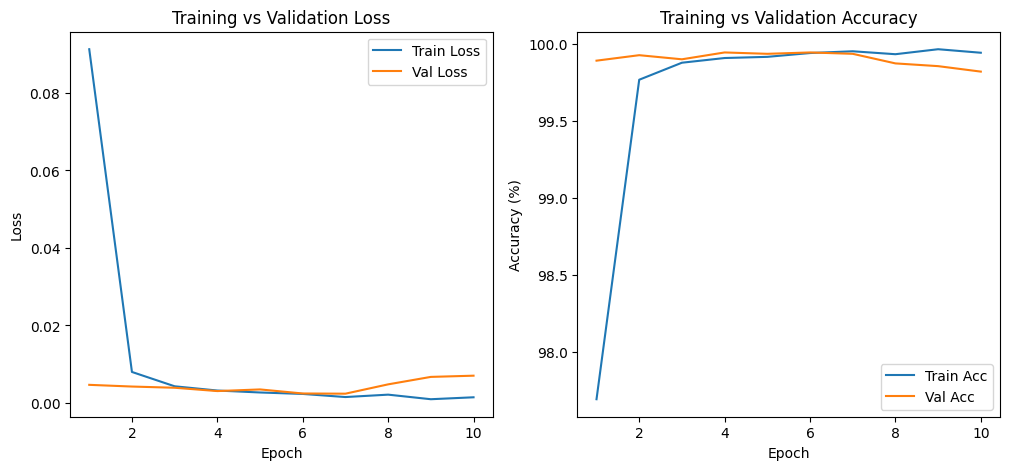

In [8]:
# Record time
since = time.time()
best_acc = 0.0

# Store history 
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    # Training 
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = train_loss / len(train_loader)

    # Validation 
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)

    print(f"train Loss: {train_loss:.4f} Acc: {train_acc:.2f}%")
    print(f"val   Loss: {val_loss:.4f} Acc: {val_acc:.2f}%\n")

    # Save metrics for plotting 
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())

# Final Summary
time_elapsed = time.time() - since
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
print(f"Best val Acc: {best_acc:.2f}%")

# Plot curves 
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

## Save Model

In [9]:
save_path = r"C:\Users\ChrisBear\Python 3 General Notebook\Indonesia AI\Rice Type Classification\resnet50_rice_classifier.pth"
torch.save(best_model, save_path)

print(f"Model saved at: {save_path}")

Model saved at: C:\Users\ChrisBear\Python 3 General Notebook\Indonesia AI\Rice Type Classification\resnet50_rice_classifier.pth


## Load Model

In [10]:
save_path = r"C:\Users\ChrisBear\Python 3 General Notebook\Indonesia AI\Rice Type Classification\resnet50_rice_classifier.pth"

model.load_state_dict(torch.load(save_path, map_location=device))

<All keys matched successfully>

## Final Test Evaluation and Summary

Testing: 100%|██████████| 469/469 [00:34<00:00, 13.69batch/s]



Final Test Accuracy: 99.88% 



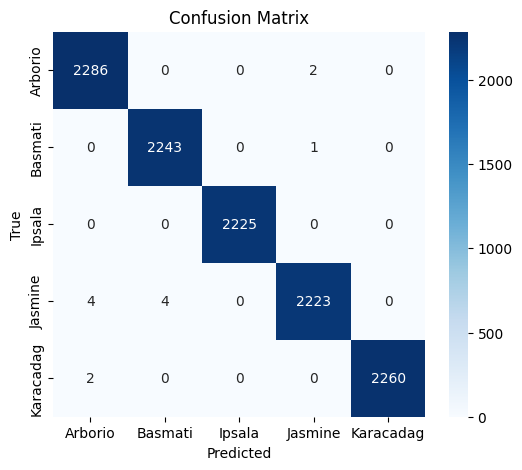


Classification Report:

              precision    recall  f1-score   support

     Arborio     0.9974    0.9991    0.9983      2288
     Basmati     0.9982    0.9996    0.9989      2244
      Ipsala     1.0000    1.0000    1.0000      2225
     Jasmine     0.9987    0.9964    0.9975      2231
   Karacadag     1.0000    0.9991    0.9996      2262

    accuracy                         0.9988     11250
   macro avg     0.9989    0.9988    0.9988     11250
weighted avg     0.9988    0.9988    0.9988     11250

Macro F1 Score: 0.9988


In [11]:
# Test model on test set and get prediction
model.eval()
test_correct, test_total = 0, 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        # Collect predictions + labels for later
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Accuracy 
test_acc = 100 * test_correct / test_total
print(f"\nFinal Test Accuracy: {test_acc:.2f}% \n")

# Confusion Matrix 
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.dataset.classes  # class labels from ImageFolder

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1 
print("\nClassification Report:\n")
print(classification_report(
    all_labels, all_preds,
    target_names=class_names,
    digits=4
))

# Macro F1 
macro_f1 = f1_score(all_labels, all_preds, average="macro")
print(f"Macro F1 Score: {macro_f1:.4f}")

## Inference

In [12]:
def predict_image(image_bytes, model, class_map, device):

    # Open image
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

    # Same transform as validation/test
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Preprocess
    input_tensor = inference_transform(image).unsqueeze(0).to(device)

    # Prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)  # convert logits -> probabilities
        confidence, predicted = torch.max(probs, 1)

    predicted_class = class_map[predicted.item()]
    confidence = confidence.item() * 100  # scale to percentage

    return predicted_class, confidence

In [13]:
# Upload widget
upload_widget = FileUpload(accept='image/*', multiple=False)
display(upload_widget)

FileUpload(value=(), accept='image/*', description='Upload')

In [14]:
# Inference
if len(upload_widget.value) == 0:
    print("Please upload an image first.")
else:
    # Extract uploaded file
    uploaded_file = upload_widget.value[0]
    image_data = uploaded_file['content']

    # Load class mapping
    idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

    # Predict
    predicted_class, confidence = predict_image(image_data, model, idx_to_class, device)

    print(f"Predicted rice type: {predicted_class} ({confidence:.2f}% confidence)")

Predicted rice type: Ipsala (90.03% confidence)
